In [3]:
!python -V


Python 3.10.11


In [4]:
import pandas as pd

In [5]:
data_path = '/opt/ml/input/data/'

train = pd.read_csv(data_path+'train_data.csv')

train.head()

userID assessmentItemID      testId  answerCode            Timestamp  \
0       0       A060001001  A060000001           1  2020-03-24 00:17:11   
1       0       A060001002  A060000001           1  2020-03-24 00:17:14   
2       0       A060001003  A060000001           1  2020-03-24 00:17:22   
3       0       A060001004  A060000001           1  2020-03-24 00:17:29   
4       0       A060001005  A060000001           1  2020-03-24 00:17:36   

   KnowledgeTag  
0          7224  
1          7225  
2          7225  
3          7225  
4          7225

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2266586 entries, 0 to 2266585
Data columns (total 6 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   userID            int64 
 1   assessmentItemID  object
 2   testId            object
 3   answerCode        int64 
 4   Timestamp         object
 5   KnowledgeTag      int64 
dtypes: int64(3), object(3)
memory usage: 103.8+ MB


### 0. 라이브러리

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(color_codes=True)
import missingno as msno

In [7]:
%%time
dtype = {
    'userID' : 'int16',
    'answerCode' : 'int16',
    'KnowledgeTag' : 'int16'
}

data_path = '/opt/ml/input/data/train_data.csv'
df = pd.read_csv(data_path)
df = df.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)

CPU times: user 7.82 s, sys: 464 ms, total: 8.29 s
Wall time: 8.29 s


### 1-1 기본내용파악

In [6]:
df

userID assessmentItemID      testId  answerCode            Timestamp  \
0             0       A060001001  A060000001           1  2020-03-24 00:17:11   
1             0       A060001002  A060000001           1  2020-03-24 00:17:14   
2             0       A060001003  A060000001           1  2020-03-24 00:17:22   
3             0       A060001004  A060000001           1  2020-03-24 00:17:29   
4             0       A060001005  A060000001           1  2020-03-24 00:17:36   
...         ...              ...         ...         ...                  ...   
2266581    7441       A030071005  A030000071           0  2020-06-05 06:50:21   
2266582    7441       A040165001  A040000165           1  2020-08-21 01:06:39   
2266583    7441       A040165002  A040000165           1  2020-08-21 01:06:50   
2266584    7441       A040165003  A040000165           1  2020-08-21 01:07:36   
2266585    7441       A040165004  A040000165           1  2020-08-21 01:08:49   

         KnowledgeTag  
0                7224  
1                7225  
2                7225  
3                7225  
4                7225  
...               ...  
2266581           438  
2266582          8836  
2266583          8836  
2266584          8836  
2266585          8836  

[2266586 rows x 6 columns]

In [7]:
print(f"""--- BASIC INFORMATIONS ---
userID           : {df.userID.nunique()}
assessmentItemID : {df.assessmentItemID.nunique()}
testID           : {df.testId.nunique()}
mean answer rate : {df.answerCode.sum() / df.shape[0] * 100:.2f}%
KnowledgeTag     : {df.KnowledgeTag.nunique()}
{'-'*26}""")

--- BASIC INFORMATIONS ---
userID           : 6698
assessmentItemID : 9454
testID           : 1537
mean answer rate : 65.44%
KnowledgeTag     : 912
--------------------------


In [9]:
# assessmentItemID의 첫글자가 모두 A인가?
df['assessmentItemID'].apply(lambda x:x[0]).unique()

array(['A'], dtype=object)

In [10]:
# assessmentItemID의 두번째 글자 부터 여덟번째 글자 까지 = 시험지
df['assessmentItemID'].apply(lambda x:x[1:7]).nunique()

1537

In [11]:
# assessmentItemID의 두번째 글자 부터 여덟번째 글자 까지 = 시험지
sum(df['assessmentItemID'].apply(lambda x : x[1:7]) == df['testId'].apply(lambda x: x[1:4] + x[7:]))

2266586

In [12]:
# 시험지의 중간 글자는 모두 000 인가?
df['testId'].apply(lambda x: x[4:7]).unique()

array(['000'], dtype=object)

### 1-2 기술 통계량 분석

#### 사용자 분석

In [13]:
def percentile(s):
    return np.sum(s) / len(s)

In [14]:
# user 별로 groupby를 수행
# 각 유저별로 푼 문제수 / 정답률
stu_groupby = df.groupby('userID').agg({'assessmentItemID': 'count', 'answerCode' : percentile })

stu_groupby

assessmentItemID  answerCode
userID                              
0                    745    0.630872
1                    933    0.853162
2                    276    0.612319
5                    833    0.795918
6                    921    0.442997
...                  ...         ...
7436                  15    0.466667
7437                  16    0.375000
7438                  16    0.750000
7440                  15    0.400000
7441                   9    0.555556

[6698 rows x 2 columns]

In [15]:
stu_groupby.describe()

assessmentItemID   answerCode
count       6698.000000  6698.000000
mean         338.397432     0.628909
std          321.331429     0.159639
min            9.000000     0.000000
25%           78.000000     0.527273
50%          231.500000     0.651757
75%          513.000000     0.751203
max         1860.000000     1.000000

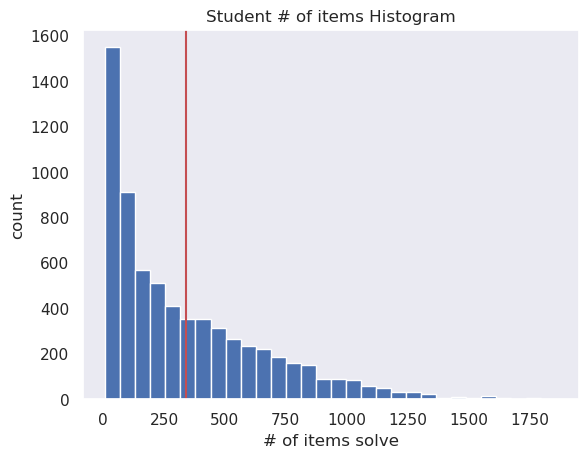

In [15]:
# 사용자당 문제를 얼마나 풀었는지에 대해 분포를 그려보자

fig, ax = plt.subplots()

stu_groupby['assessmentItemID'].hist(bins=30, ax=ax)

ax.set_title('Student # of items Histogram')
ax.set_xlabel('# of items solve')
ax.set_ylabel('count')
ax.axvline(stu_groupby['assessmentItemID'].mean(), color='r')
ax.grid()

<Axes: >

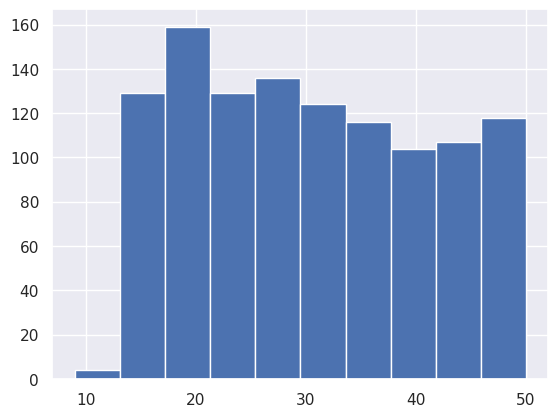

In [16]:
# 0부터 50까지의 푼사람의 비율이 대체적으로 많아 푼 문제수가 50이하인 유저를 대상으로 분포를 알아보기 위함
stu_groupby[stu_groupby['assessmentItemID'] <= 50]['assessmentItemID'].hist()

In [17]:
# 1250문제 이상 푼사람이 얼마나 되는지 알고 싶다.
stu_groupby[stu_groupby['assessmentItemID'] >= 1250]

assessmentItemID  answerCode
userID                              
16                  1278    0.820031
23                  1555    0.894534
27                  1468    0.677112
50                  1320    0.831818
51                  1662    0.888688
...                  ...         ...
1872                1406    0.729730
1967                1318    0.468134
1978                1443    0.721414
2396                1280    0.557813
2802                1250    0.721600

[103 rows x 2 columns]

In [18]:
# 1250문제 이상 푼 학생의 수는 103명 정도이다. 바로위의 그래프를 보았을 때 15문제 20문제 이하로 푼 학생의 수도 100명 정도 일것이다.
# 17 문제 이하로 푼 학생의 수는 133명 정도이다.
stu_groupby[stu_groupby['assessmentItemID'] <= 17]

assessmentItemID  answerCode
userID                              
6022                  17    0.588235
6735                  17    0.411765
6750                  17    0.529412
6783                  16    0.500000
6806                  17    0.764706
...                  ...         ...
7436                  15    0.466667
7437                  16    0.375000
7438                  16    0.750000
7440                  15    0.400000
7441                   9    0.555556

[133 rows x 2 columns]

(array([ 0.,  1.,  0.,  1.,  9., 12., 19., 31., 30.,  0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

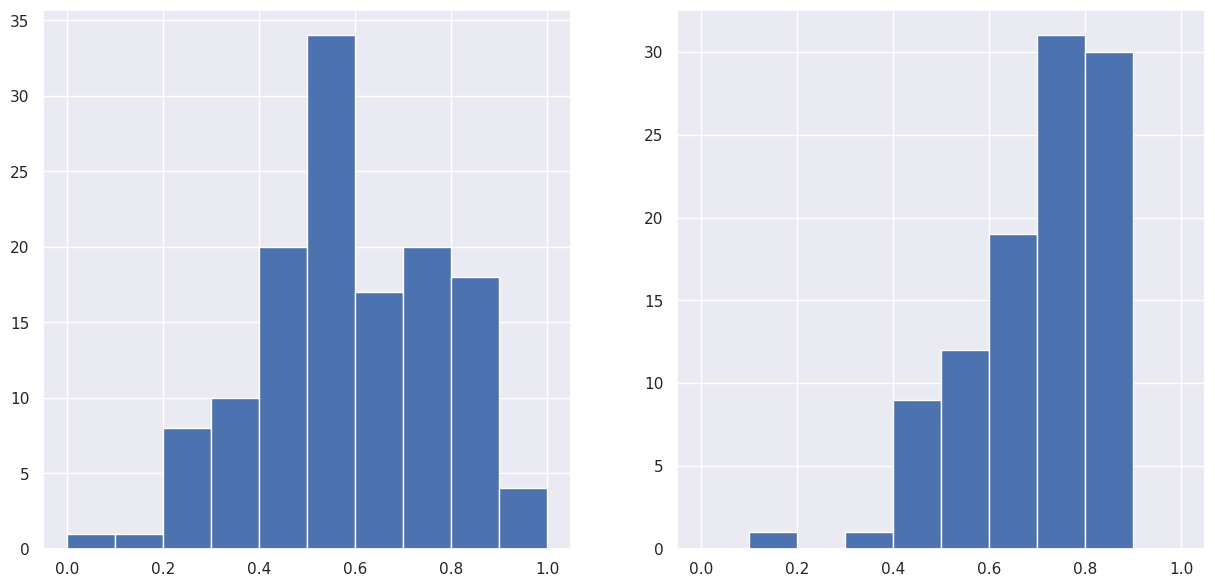

In [19]:
# 17 문제 이하로 푼 학생과 1250문제 이상으로 푼 학생의 정답률을 비교해보자

stu_17 = stu_groupby[stu_groupby['assessmentItemID']<18].sort_values(['answerCode'])
stu_1250 = stu_groupby[stu_groupby['assessmentItemID']>=1250].sort_values(['answerCode'])

fig, ax = plt.subplots(1,2,figsize=(15,7))



ax[0].hist(stu_17['answerCode'],range=(0,1) ,bins=10)
ax[1].hist(stu_1250['answerCode'],range=(0,1),bins=10)

상위 100명 하위 100명 정도 조사한 결과

In [20]:
# 900문제 이상 푼사람이 얼마나 되는지 알고 싶다.
stu_groupby[stu_groupby['assessmentItemID'] >= 900]

assessmentItemID  answerCode
userID                              
1                    933    0.853162
6                    921    0.442997
12                   939    0.604899
15                  1218    0.683087
16                  1278    0.820031
...                  ...         ...
2702                 965    0.879793
2791                 916    0.663755
2797                 981    0.808359
2802                1250    0.721600
2984                 977    0.611054

[475 rows x 2 columns]

In [21]:
stu_groupby[stu_groupby['assessmentItemID'] <= 27]

assessmentItemID  answerCode
userID                              
4610                  19    0.789474
4752                  25    0.600000
5188                  24    0.708333
5258                  27    0.555556
5361                  21    0.857143
...                  ...         ...
7436                  15    0.466667
7437                  16    0.375000
7438                  16    0.750000
7440                  15    0.400000
7441                   9    0.555556

[487 rows x 2 columns]

(array([ 0.,  1.,  0.,  1.,  9., 12., 19., 31., 30.,  0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

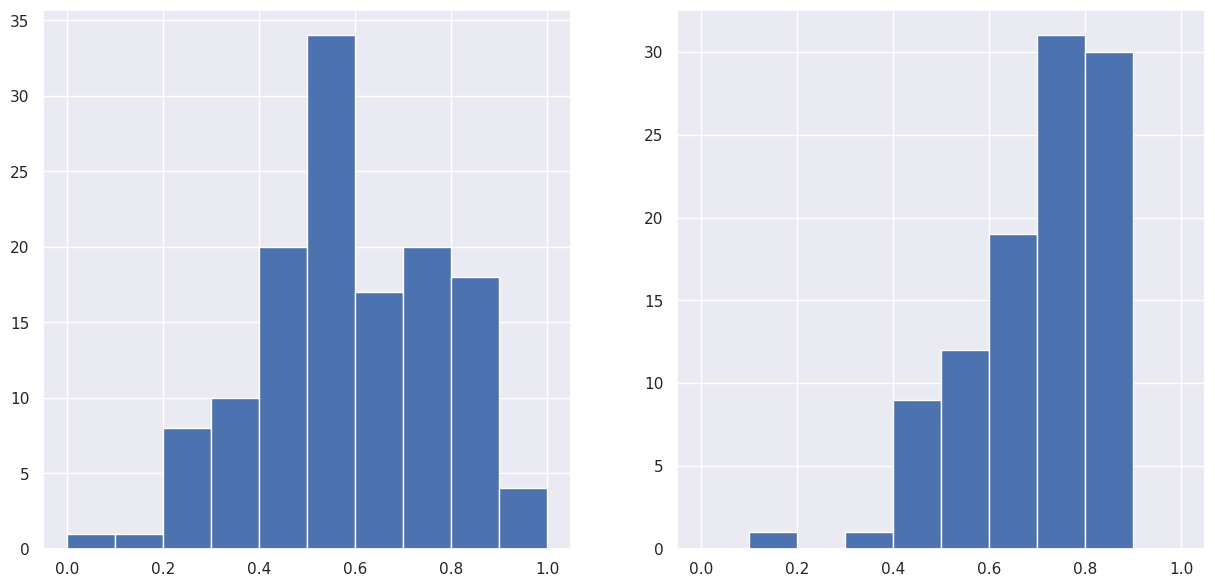

In [22]:
stu_27 = stu_groupby[stu_groupby['assessmentItemID']<28].sort_values(['answerCode'])
stu_900 = stu_groupby[stu_groupby['assessmentItemID']>=900].sort_values(['answerCode'])

fig, ax = plt.subplots(1,2,figsize=(15,7))



ax[0].hist(stu_17['answerCode'],range=(0,1) ,bins=10)
ax[1].hist(stu_1250['answerCode'],range=(0,1),bins=10)

상위 450명 하위 450명을 조사한 결과

확실하게 문제를 많이 풀 수록 정답률이 높은 것을 확인 할 수 있다.

또한 살펴볼 내용으로는 마지막문제를 맞췄는지 틀렸는지 조차도 중요하다. 사실 이게 더 중요함..

#### 문항 별 정답률 분석

In [45]:
prob_groupby = df.groupby('assessmentItemID').agg({
    'userID' : 'count',
    'answerCode' : percentile
})
prob_groupby.describe()

userID   answerCode
count  9454.000000  9454.000000
mean    239.748889     0.654256
std      71.893791     0.195488
min      43.000000     0.049430
25%     220.000000     0.505548
50%     230.000000     0.666667
75%     271.000000     0.820513
max     454.000000     0.996310

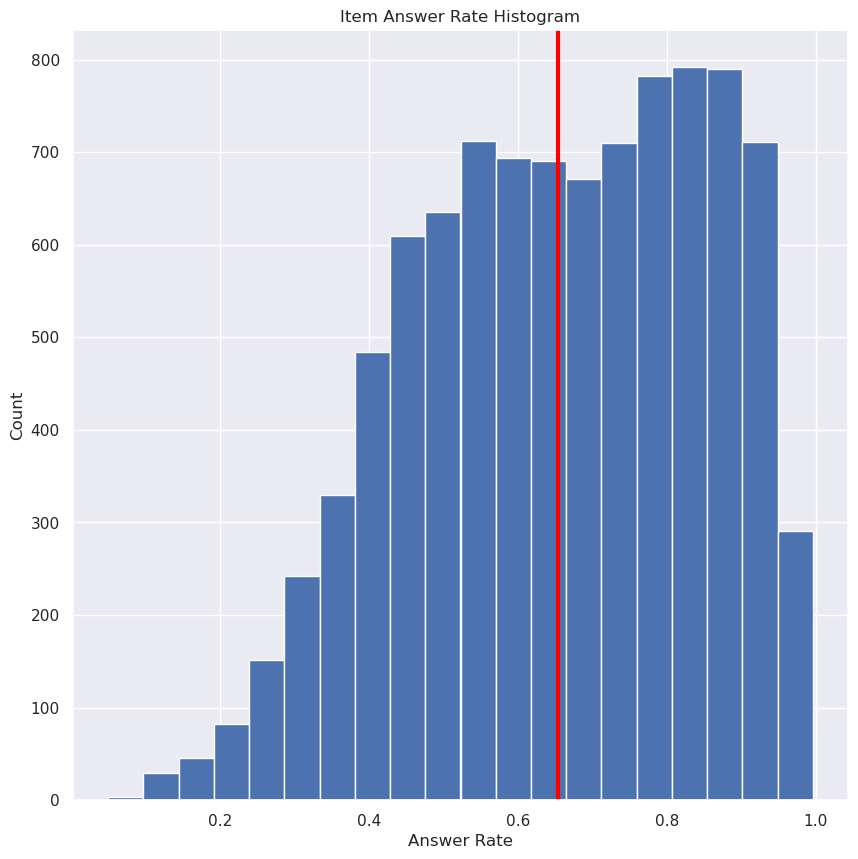

In [50]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
prob_groupby['answerCode'].hist(bins=20)

ax.set_title("Item Answer Rate Histogram")
ax.set_xlabel("Answer Rate")
ax.set_ylabel("Count")

ax.axvline(prob_groupby['answerCode'].mean(), color='red', linewidth=3)

ax.grid(True)

plt.show()

#### 시험지별 정답률 분석

In [53]:
# 기초 통계량 부터 확인해보자
test_groupby = df.groupby('testId').agg({
    'userID' : 'count',
    'answerCode' : percentile
})

test_groupby

userID  answerCode
testId                        
A010000001    1585    0.926183
A010000002    1550    0.931613
A010000003    1615    0.846440
A010000004    1540    0.883117
A010000005    1595    0.855172
...            ...         ...
A090000070     344    0.418605
A090000071     360    0.336111
A090000072     270    0.418519
A090000073     270    0.529630
A090000074     270    0.425926

[1537 rows x 2 columns]

In [54]:
test_groupby.describe()

userID   answerCode
count  1537.000000  1537.000000
mean   1474.681848     0.667982
std     533.526783     0.138903
min     172.000000     0.327186
25%    1320.000000     0.561819
50%    1400.000000     0.680519
75%    1602.000000     0.778439
max    3960.000000     0.955474

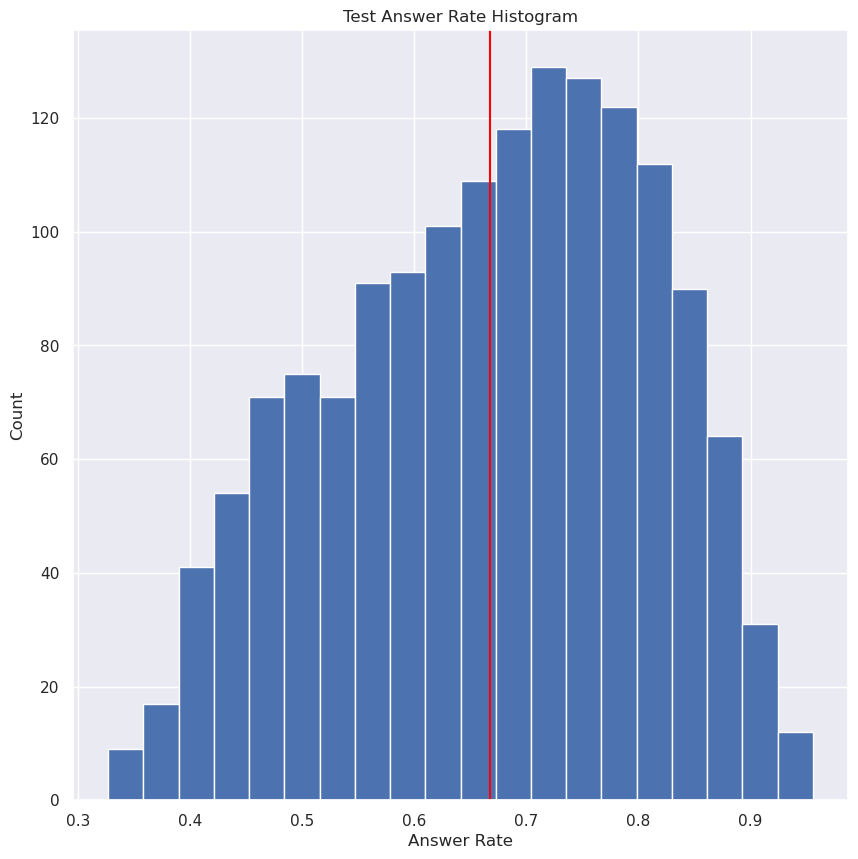

In [55]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

test_groupby['answerCode'].hist(bins=20)
ax.set_title('Test Answer Rate Histogram')
ax.set_xlabel('Answer Rate')
ax.set_ylabel('Count')

ax.axvline(test_groupby['answerCode'].mean(), color='red')

ax.grid(True)

plt.show()

### 1-3 본격적인 EDA

#### 마지막 문제 정답 유무와 푼 문제수, 정답률과의 관계

In [9]:
# 마지막 문제를 맞췄는지 틀렸는지도 중요함...
# 영향이 깊다고 한다면 sequence를 자른다고 가정했을 때 푼 문제수를 반영하면 좋을 것 같다.
# 마지막 문제에 대해 마지막문제 tag, assessmentItemID
# 마지막 것의 내용 추출하는 함수
def get_final(x):
    return x[-1:]


uid_final_groupby = df.groupby('userID').agg({'assessmentItemID': get_final , 'KnowledgeTag' : get_final, 'answerCode' : get_final})
uid_final_groupby


assessmentItemID  KnowledgeTag  answerCode
userID                                           
0            A080129006          2725           0
1            A090074006          2648           1
2            A050139007           428           0
5            A080138007          8431           1
6            A030145005          7817           0
...                 ...           ...         ...
7436         A030019001           331           0
7437         A060003007          7226           0
7438         A030188005          1934           1
7440         A030197005          1984           0
7441         A040165004          8836           1

[6698 rows x 3 columns]

In [10]:
# 기존 groupby 들고 오기
def percentile(s):
    return np.sum(s) / len(s)


stu_groupby = df.groupby('userID').agg({'assessmentItemID' : 'count', 'answerCode' : percentile})
stu_groupby.rename(columns={'assessmentItemID' : 'q_count', 'answerCode' : 'correct_answer_rate'}, inplace=True)
stu_groupby

q_count  correct_answer_rate
userID                              
0           745             0.630872
1           933             0.853162
2           276             0.612319
5           833             0.795918
6           921             0.442997
...         ...                  ...
7436         15             0.466667
7437         16             0.375000
7438         16             0.750000
7440         15             0.400000
7441          9             0.555556

[6698 rows x 2 columns]

In [11]:
# 두개의 df 합치기
groupby_df = pd.concat([stu_groupby, uid_final_groupby], axis=1)
groupby_df

q_count  correct_answer_rate assessmentItemID  KnowledgeTag  \
userID                                                                
0           745             0.630872       A080129006          2725   
1           933             0.853162       A090074006          2648   
2           276             0.612319       A050139007           428   
5           833             0.795918       A080138007          8431   
6           921             0.442997       A030145005          7817   
...         ...                  ...              ...           ...   
7436         15             0.466667       A030019001           331   
7437         16             0.375000       A060003007          7226   
7438         16             0.750000       A030188005          1934   
7440         15             0.400000       A030197005          1984   
7441          9             0.555556       A040165004          8836   

        answerCode  
userID              
0                0  
1                1  
2                0  
5                1  
6                0  
...            ...  
7436             0  
7437             0  
7438             1  
7440             0  
7441             1  

[6698 rows x 5 columns]

In [12]:
groupby_df.describe()

q_count  correct_answer_rate  KnowledgeTag   answerCode
count  6698.000000          6698.000000   6698.000000  6698.000000
mean    338.397432             0.628909   5420.311138     0.478949
std     321.331429             0.159639   3438.538960     0.499594
min       9.000000             0.000000     23.000000     0.000000
25%      78.000000             0.527273   1964.000000     0.000000
50%     231.500000             0.651757   7075.000000     0.000000
75%     513.000000             0.751203   8403.000000     1.000000
max    1860.000000             1.000000  11269.000000     1.000000

In [13]:
# 공분산 확인
groupby_df.corr()

/tmp/ipykernel_28963/2635759632.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  groupby_df.corr()


q_count  correct_answer_rate  KnowledgeTag  answerCode
q_count              1.000000             0.168041      0.097558    0.009200
correct_answer_rate  0.168041             1.000000     -0.010331    0.260670
KnowledgeTag         0.097558            -0.010331      1.000000    0.004697
answerCode           0.009200             0.260670      0.004697    1.000000

0    636
1    490
Name: answerCode, dtype: int64


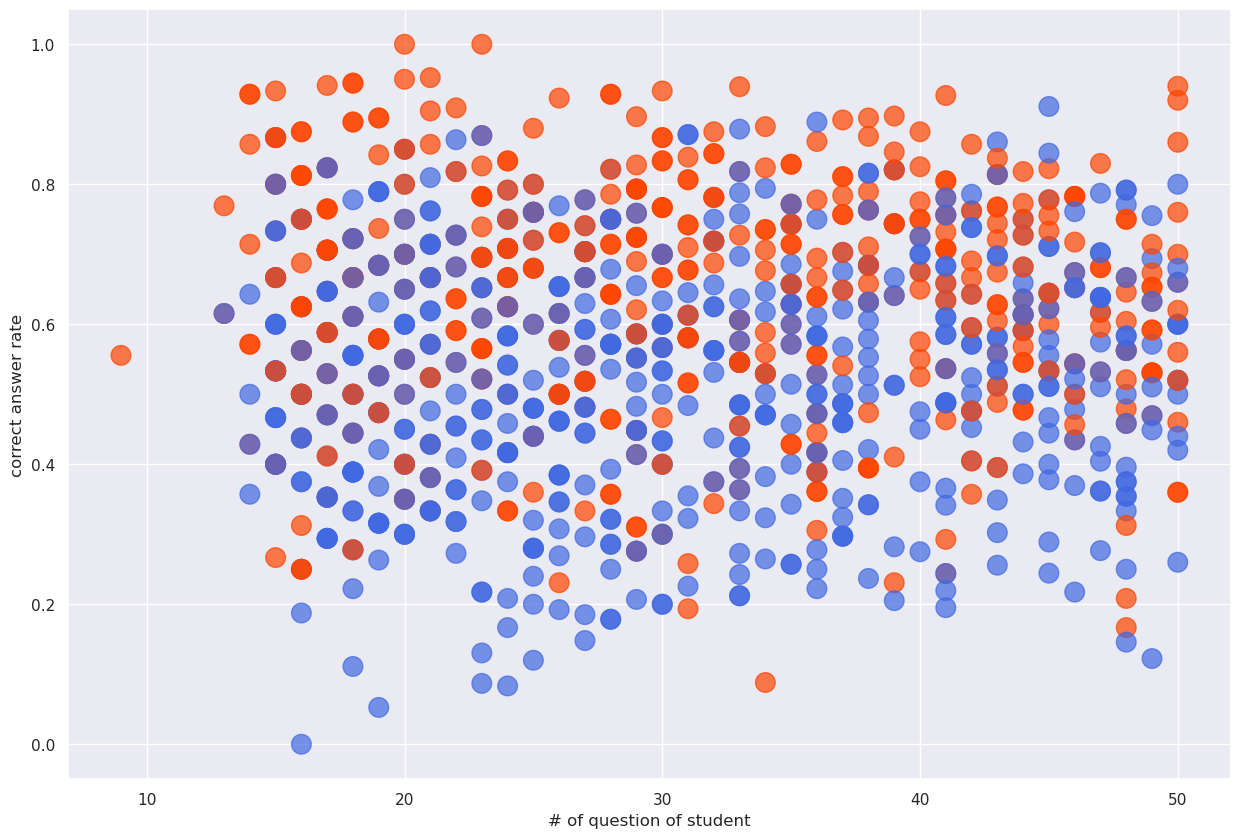

In [ ]:
df_qcount_50 = groupby_df[groupby_df['q_count'] <= 50]

# count를 확인해보자
print(df_qcount_50['answerCode'].value_counts())

# scatter
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,1,1)

ax.scatter(x = df_qcount_50['q_count'],
           y = df_qcount_50['correct_answer_rate'],
           c = ['orangered' if ac == 1 else 'royalblue' for ac in df_qcount_50['answerCode']],
           alpha=0.7,
           s = 200)


ax.set_xlabel('# of question of student')
ax.set_ylabel('correct answer rate')

plt.show()



0    468
1    441
Name: answerCode, dtype: int64


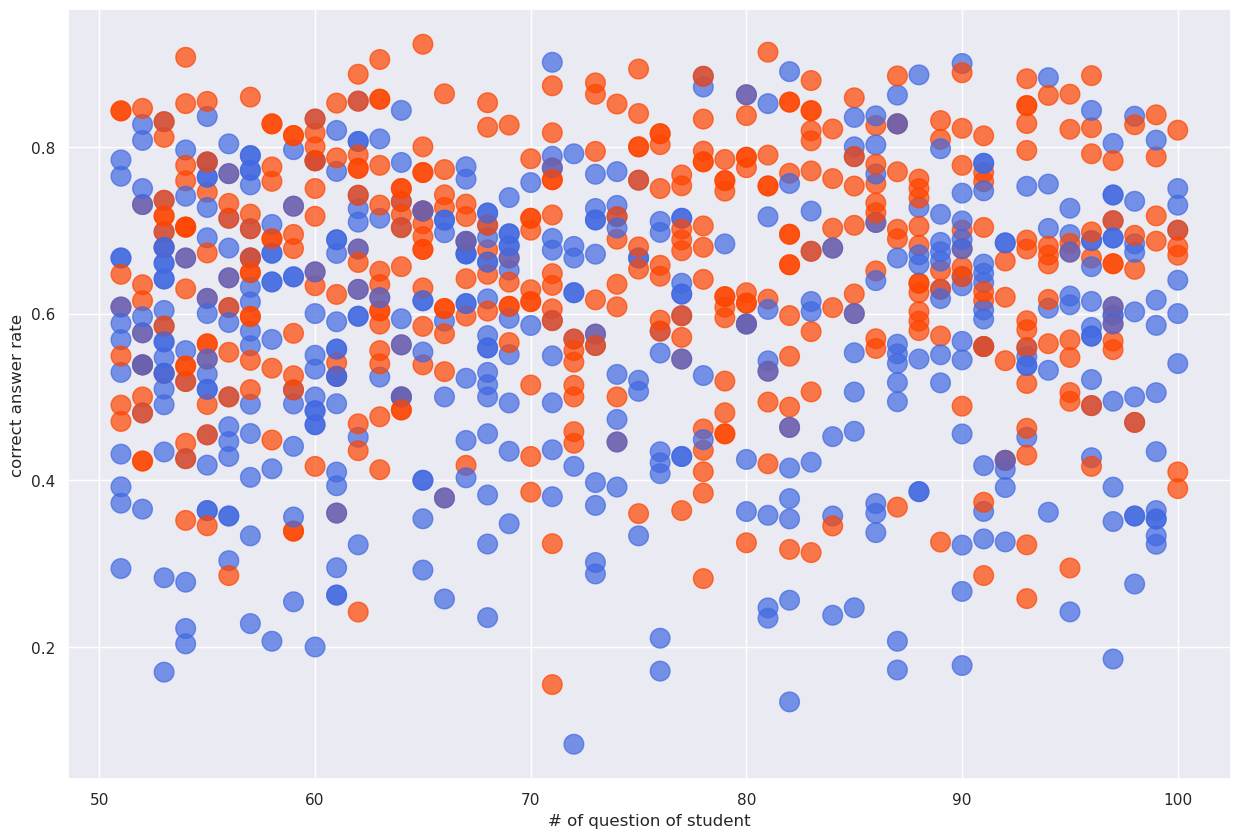

In [ ]:
df_qcount_100 = groupby_df[(groupby_df['q_count'] > 50) & (groupby_df['q_count'] <= 100)]

# count를 확인해보자
print(df_qcount_100['answerCode'].value_counts())

# scatter
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,1,1)

ax.scatter(x = df_qcount_100['q_count'],
           y = df_qcount_100['correct_answer_rate'],
           c = ['orangered' if ac == 1 else 'royalblue' for ac in df_qcount_100['answerCode']],
           alpha=0.7,
           s = 200)


ax.set_xlabel('# of question of student')
ax.set_ylabel('correct answer rate')

plt.show()


0    531
1    507
Name: answerCode, dtype: int64


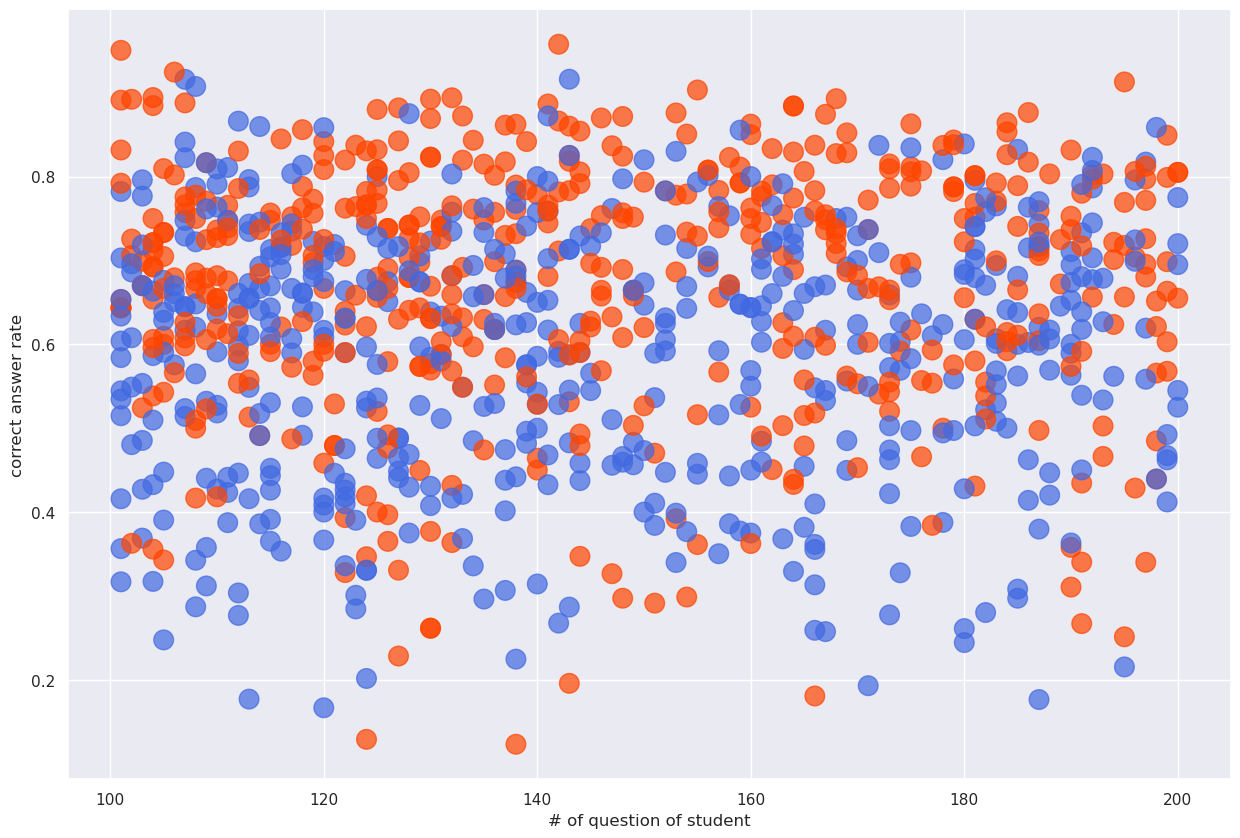

In [ ]:
df_qcount_200 = groupby_df[(groupby_df['q_count'] > 100) & (groupby_df['q_count'] <= 200)]

# count를 확인해보자
print(df_qcount_200['answerCode'].value_counts())

# scatter
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,1,1)

ax.scatter(x = df_qcount_200['q_count'],
           y = df_qcount_200['correct_answer_rate'],
           c = ['orangered' if ac == 1 else 'royalblue' for ac in df_qcount_200['answerCode']],
           alpha=0.7,
           s = 200)


ax.set_xlabel('# of question of student')
ax.set_ylabel('correct answer rate')

plt.show()


1    396
0    376
Name: answerCode, dtype: int64


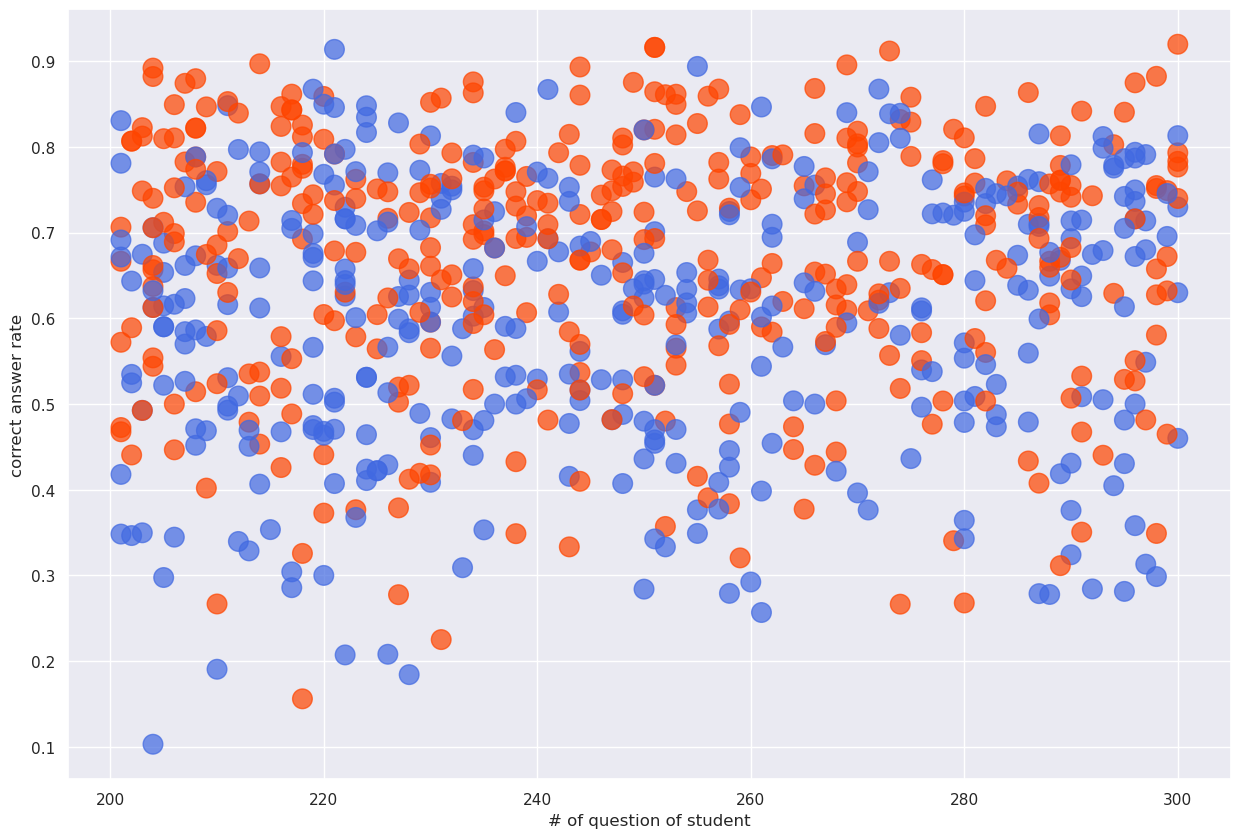

In [ ]:
df_qcount_300 = groupby_df[(groupby_df['q_count'] > 200) & (groupby_df['q_count'] <= 300)]

# count를 확인해보자
print(df_qcount_300['answerCode'].value_counts())

# scatter
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,1,1)

ax.scatter(x = df_qcount_300['q_count'],
           y = df_qcount_300['correct_answer_rate'],
           c = ['orangered' if ac == 1 else 'royalblue' for ac in df_qcount_300['answerCode']],
           alpha=0.7,
           s = 200)


ax.set_xlabel('# of question of student')
ax.set_ylabel('correct answer rate')

plt.show()


0    286
1    284
Name: answerCode, dtype: int64


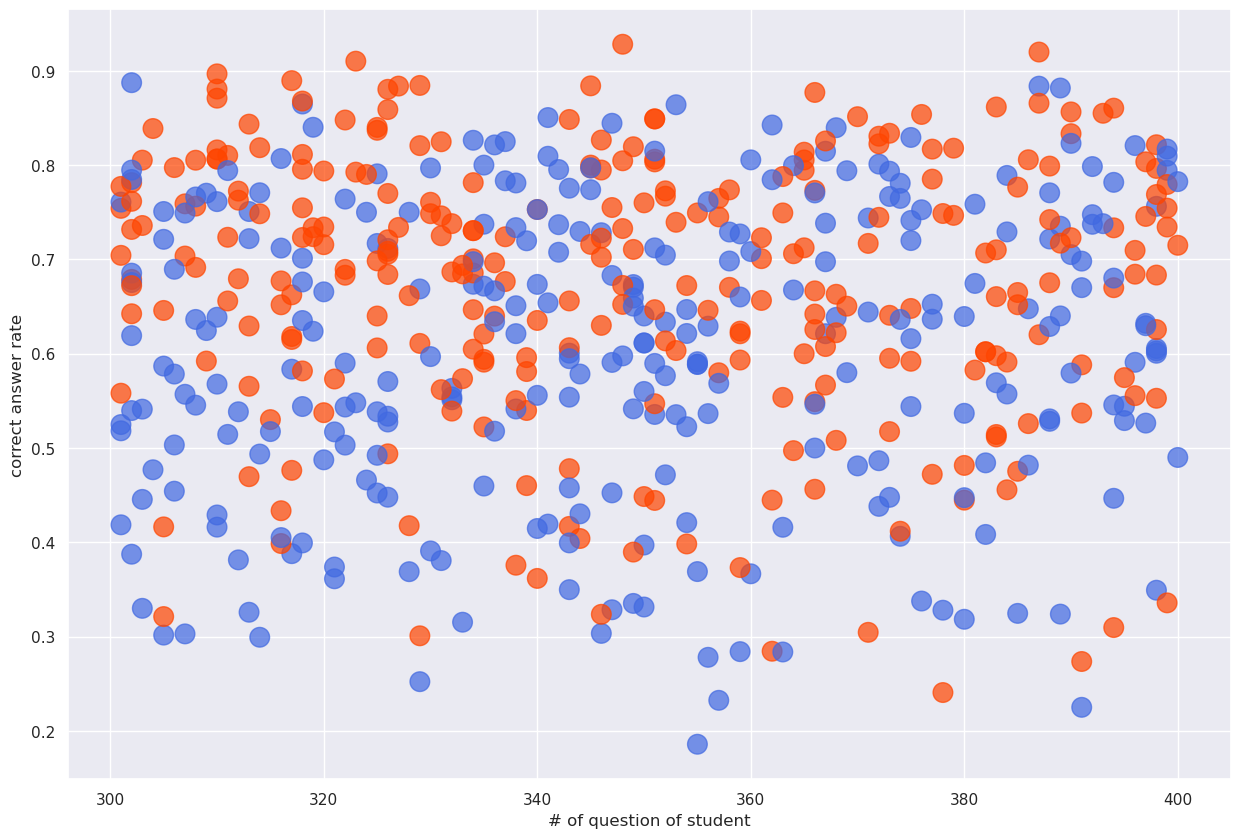

In [ ]:
df_qcount_400 = groupby_df[(groupby_df['q_count'] > 300) & (groupby_df['q_count'] <= 400)]

# count를 확인해보자
print(df_qcount_400['answerCode'].value_counts())

# scatter
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,1,1)

ax.scatter(x = df_qcount_400['q_count'],
           y = df_qcount_400['correct_answer_rate'],
           c = ['orangered' if ac == 1 else 'royalblue' for ac in df_qcount_400['answerCode']],
           alpha=0.7,
           s = 200)


ax.set_xlabel('# of question of student')
ax.set_ylabel('correct answer rate')

plt.show()

0    294
1    249
Name: answerCode, dtype: int64


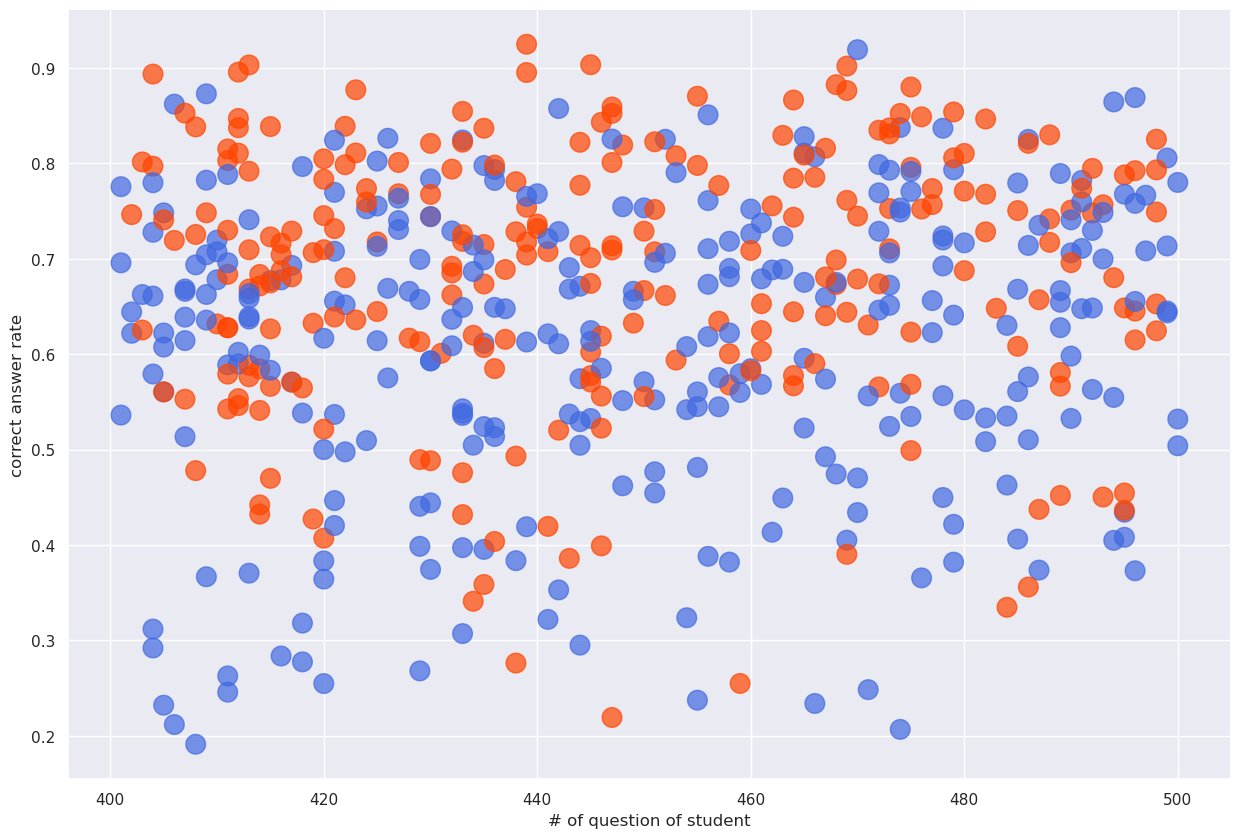

In [ ]:
df_qcount_500 = groupby_df[(groupby_df['q_count'] > 400) & (groupby_df['q_count'] <= 500)]

# count를 확인해보자
print(df_qcount_500['answerCode'].value_counts())

# scatter
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,1,1)

ax.scatter(x = df_qcount_500['q_count'],
           y = df_qcount_500['correct_answer_rate'],
           c = ['orangered' if ac == 1 else 'royalblue' for ac in df_qcount_500['answerCode']],
           alpha=0.7,
           s = 200)


ax.set_xlabel('# of question of student')
ax.set_ylabel('correct answer rate')

plt.show()

0    467
1    454
Name: answerCode, dtype: int64


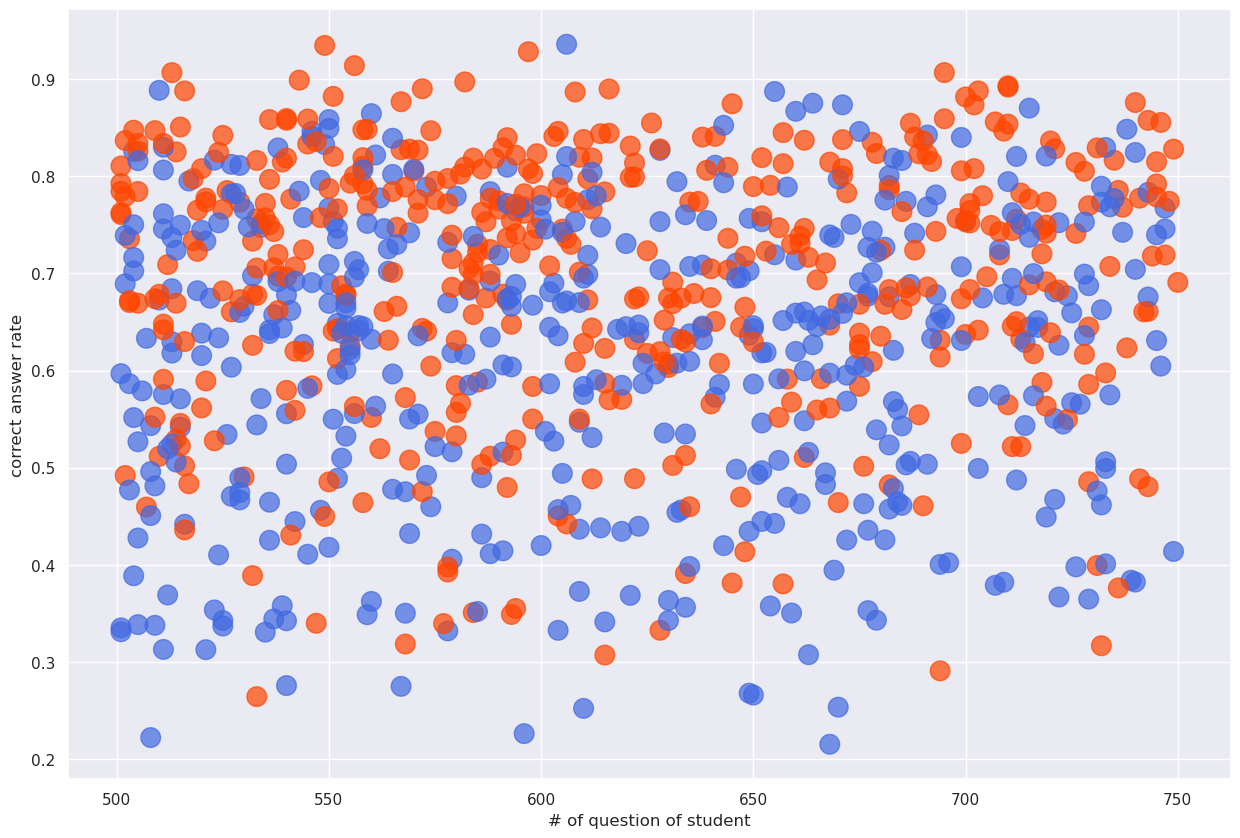

In [ ]:
df_qcount_750 = groupby_df[(groupby_df['q_count'] > 500) & (groupby_df['q_count'] <= 750)]

# count를 확인해보자
print(df_qcount_750['answerCode'].value_counts())

# scatter
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,1,1)

ax.scatter(x = df_qcount_750['q_count'],
           y = df_qcount_750['correct_answer_rate'],
           c = ['orangered' if ac == 1 else 'royalblue' for ac in df_qcount_750['answerCode']],
           alpha=0.7,
           s = 200)


ax.set_xlabel('# of question of student')
ax.set_ylabel('correct answer rate')

plt.show()

0    262
1    236
Name: answerCode, dtype: int64


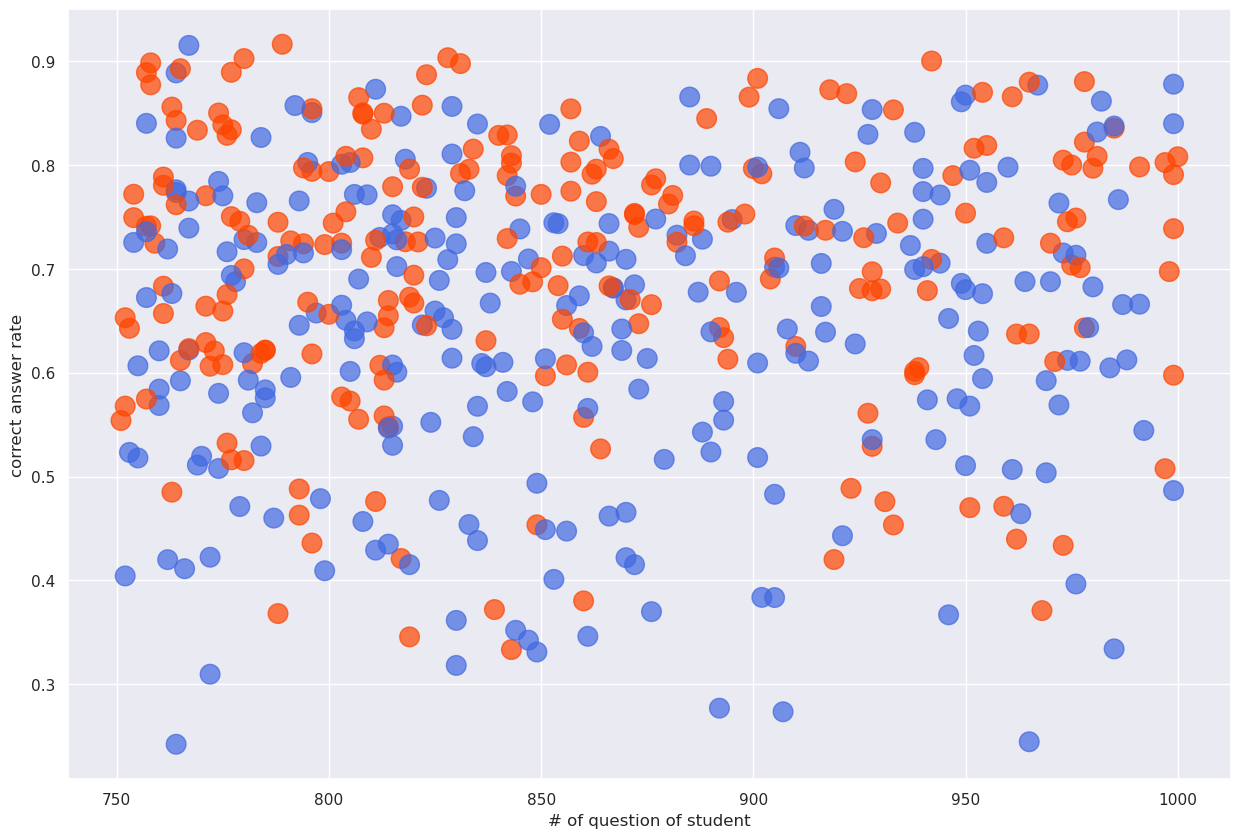

In [ ]:
df_qcount_1000 = groupby_df[(groupby_df['q_count'] > 750) & (groupby_df['q_count'] <= 1000)]

# count를 확인해보자
print(df_qcount_1000['answerCode'].value_counts())

# scatter
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,1,1)

ax.scatter(x = df_qcount_1000['q_count'],
           y = df_qcount_1000['correct_answer_rate'],
           c = ['orangered' if ac == 1 else 'royalblue' for ac in df_qcount_1000['answerCode']],
           alpha=0.7,
           s = 200)


ax.set_xlabel('# of question of student')
ax.set_ylabel('correct answer rate')

plt.show()

0    170
1    151
Name: answerCode, dtype: int64


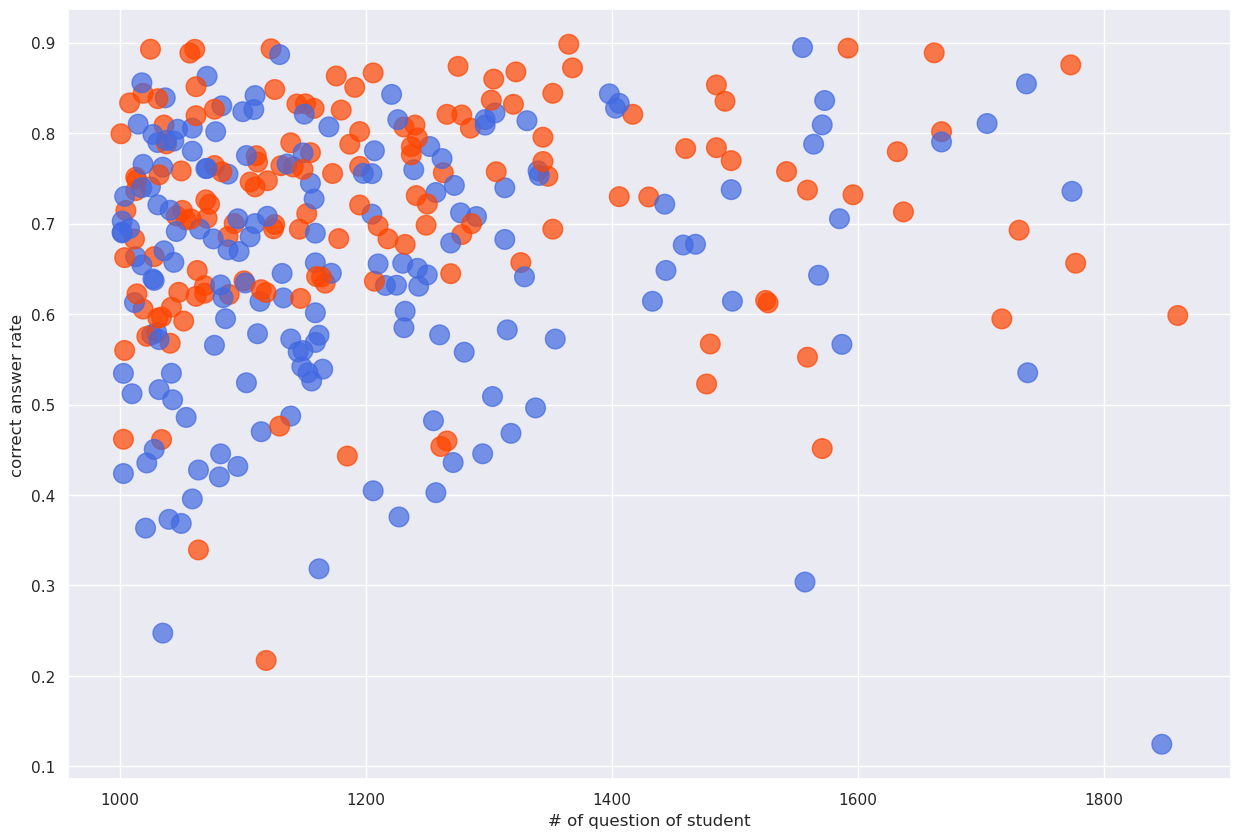

In [ ]:
df_qcount_1800 = groupby_df[groupby_df['q_count'] > 1000]

# count를 확인해보자
print(df_qcount_1800['answerCode'].value_counts())

# scatter
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,1,1)

ax.scatter(x = df_qcount_1800['q_count'],
           y = df_qcount_1800['correct_answer_rate'],
           c = ['orangered' if ac == 1 else 'royalblue' for ac in df_qcount_1800['answerCode']],
           alpha=0.7,
           s = 200)


ax.set_xlabel('# of question of student')
ax.set_ylabel('correct answer rate')

plt.show()

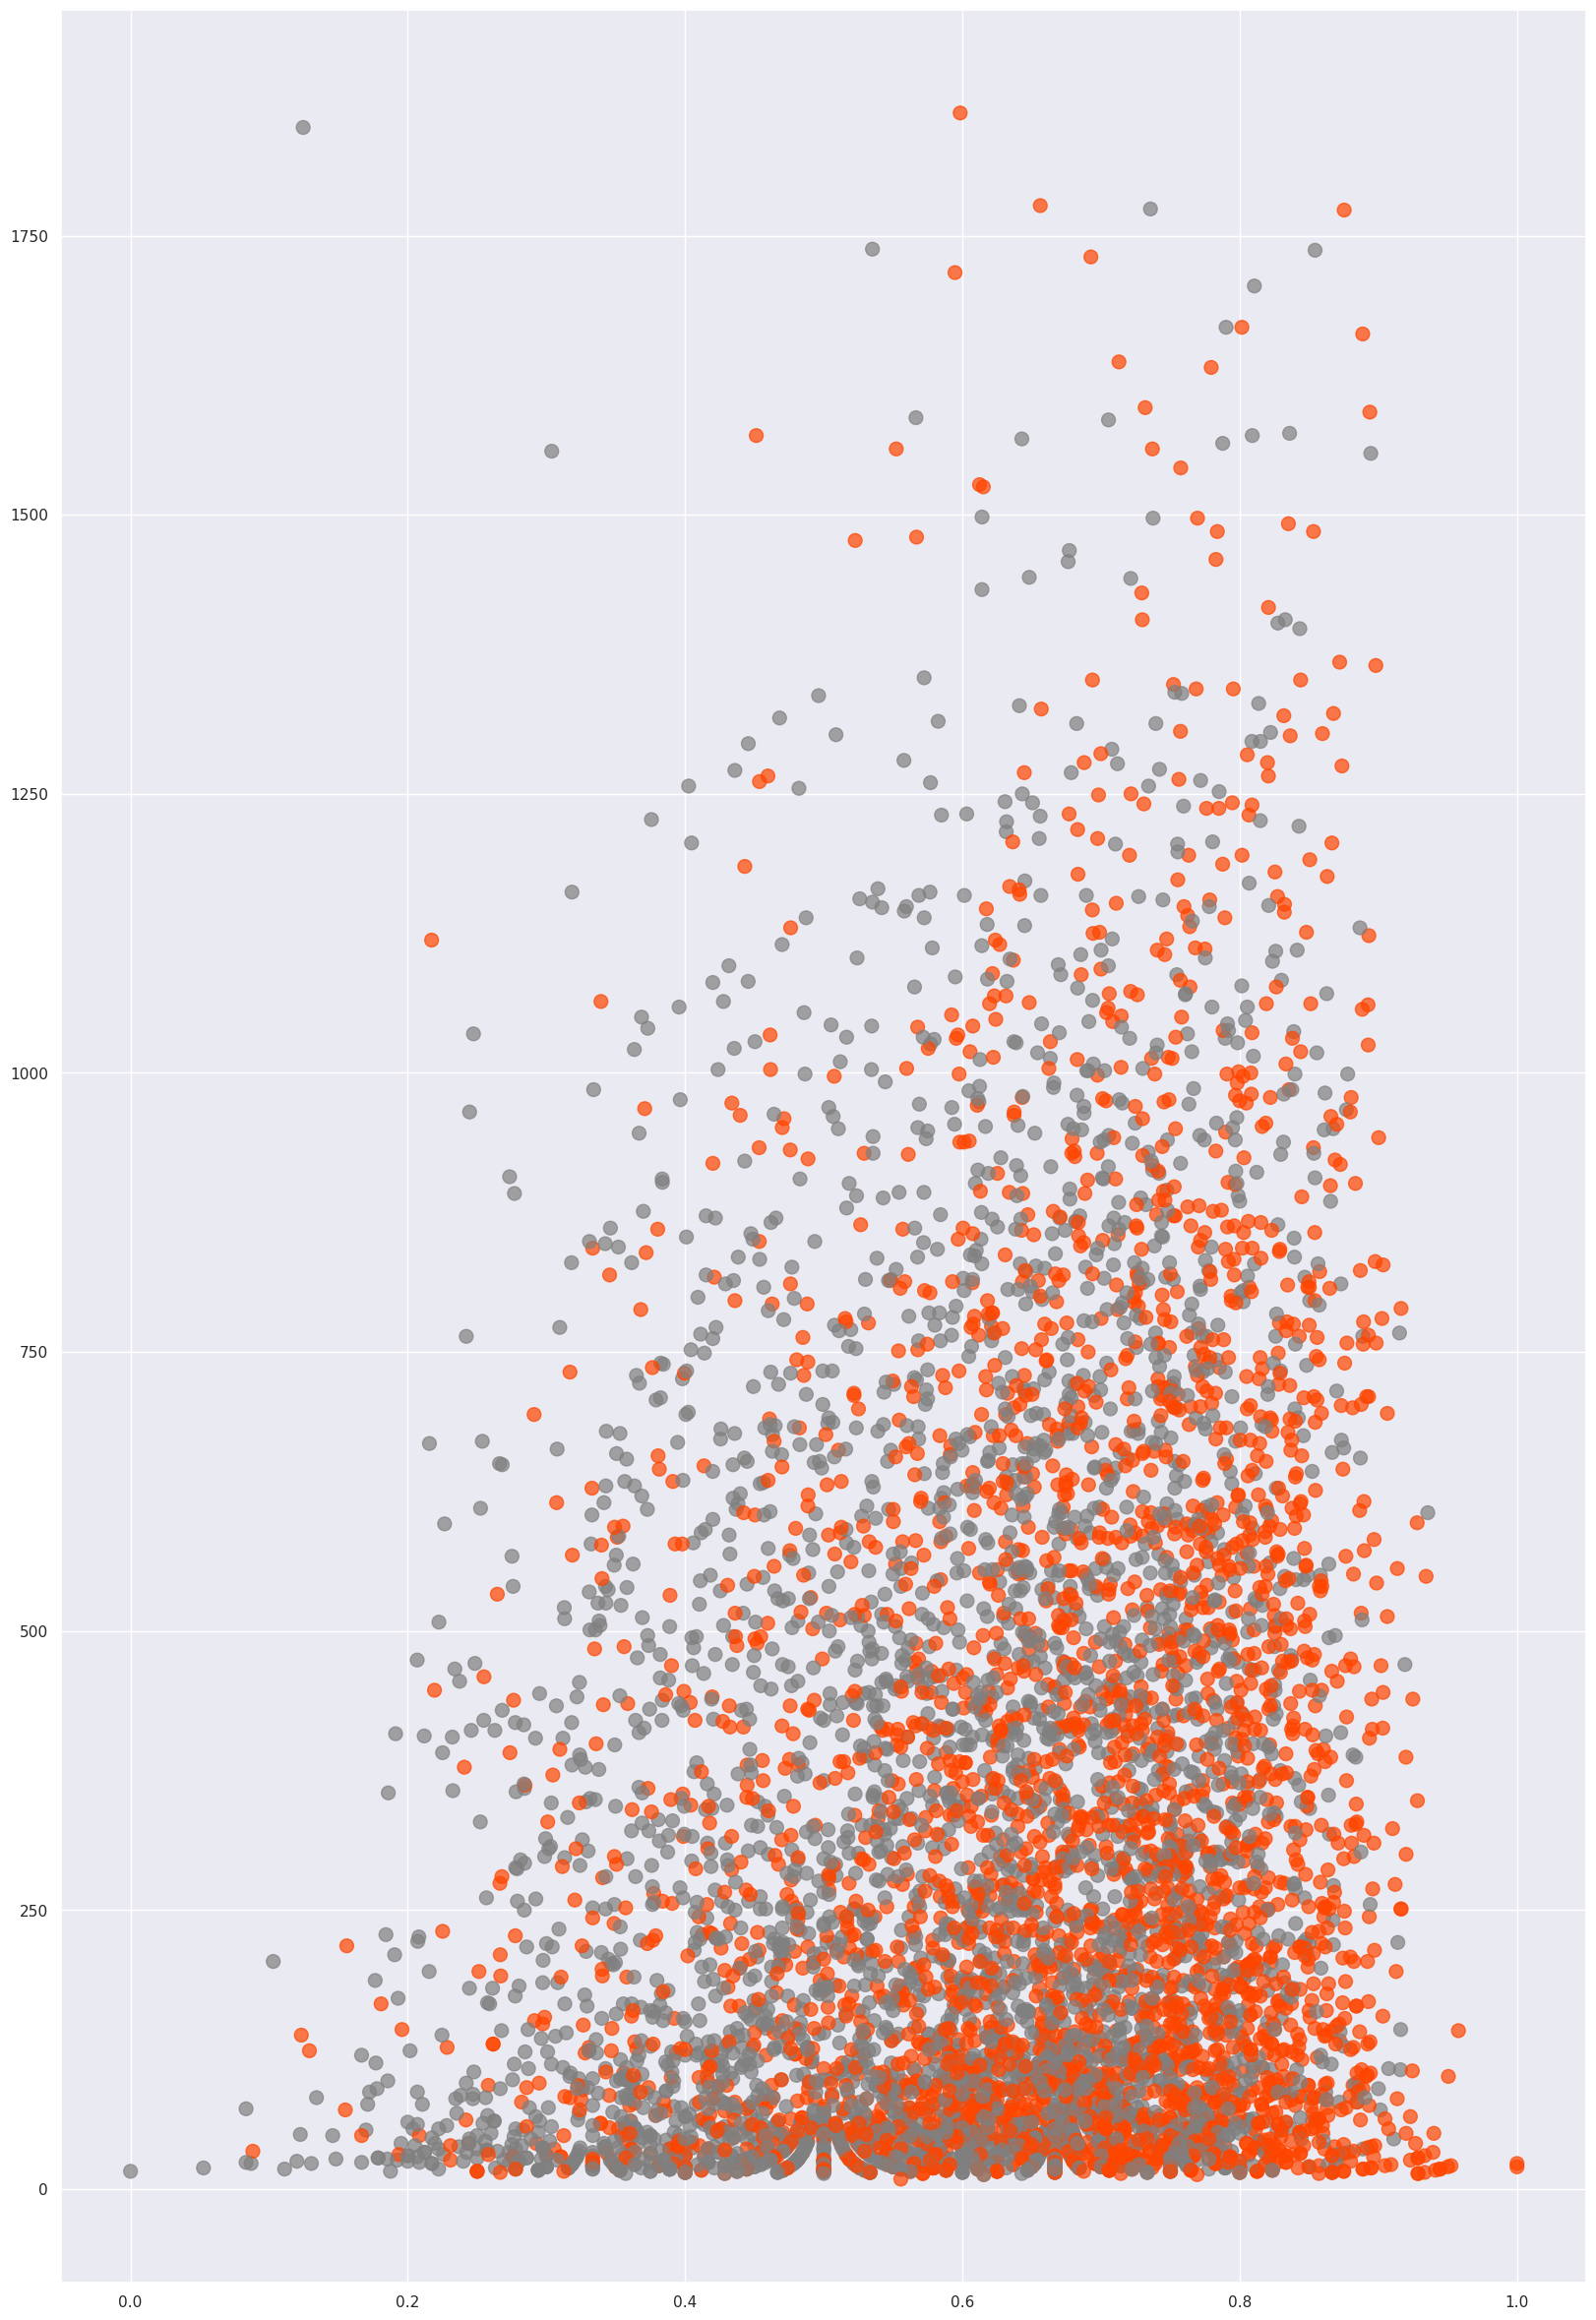

In [ ]:
# group_df에서 x축을 정답률, y축에는 푼 문제수라 하자
# 정답률이 높은 것에 색을 좀 더 진하게 칠해서 표현해보자

fig = plt.figure(figsize=(20, 30))
ax = fig.add_subplot(111)

ax.scatter(x = groupby_df['correct_answer_rate'],
           y = groupby_df['q_count'],
           c = ['orangered' if ac == 1 else 'gray' for ac in groupby_df['answerCode']],
           alpha=0.7,
           s = 100)

ax.xlabel = 'correct_rate'
ax.ylabel = '# of questions'


plt.show()

지금까지 마지막 문제를 맞췄냐 틀렸냐의 값을 가지고 색을 다르게 해서 산점도를 나타내어 보았다 그 결과 값 정답률이 높을 수록 즉 x값이 클수록 맞춘사람의 빈도는 늘어난다 라는 것은 확인이 어느정도는 가능하나 푼 문제 수와는 크게 연관성이 없어 보인다.

#### 푼 문제의 수와 정답률 사이 상관관계

In [15]:
def percentile(s):
    return np.sum(s) / len(s)

In [16]:
# data groupby

stu_groupby = df.groupby('userID').agg({'assessmentItemID': 'count', 'answerCode' : percentile })

stu_groupby.describe()

assessmentItemID   answerCode
count       6698.000000  6698.000000
mean         338.397432     0.628909
std          321.331429     0.159639
min            9.000000     0.000000
25%           78.000000     0.527273
50%          231.500000     0.651757
75%          513.000000     0.751203
max         1860.000000     1.000000

Text(0.5, 1.0, '# of Questions - Answer Rate')

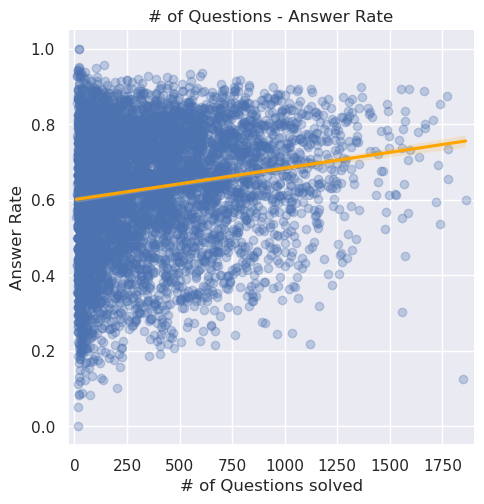

In [17]:
# seaborn의 lmplot을 사용
g = sns.lmplot(
    data = stu_groupby,
    x = 'assessmentItemID',
    y = 'answerCode',
    scatter_kws = {'alpha' : 0.3},
    line_kws = {"color" : 'orange'}
)

g.set_xlabels('# of Questions solved')
g.set_ylabels('Answer Rate')
g.set(xlim=(-30,1900))

ax = plt.gca()
ax.set_title('# of Questions - Answer Rate')



In [18]:
# 상관관계 확인
print(f"정답률과 문제를 푼 개수 사이 인과관계 : {stu_groupby.corr()['assessmentItemID']['answerCode']:.3f}")

정답률과 문제를 푼 개수 사이 인과관계 : 0.168


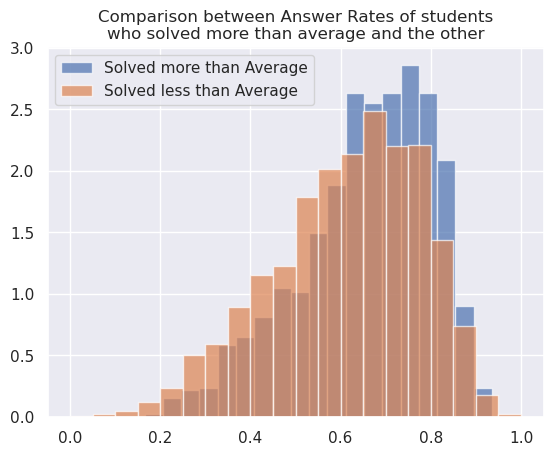

In [19]:
# 아래의 그래프는 x축은 정답률 / y축은 학생의 수
# 먼저 학생들이 몇 개의 문제를 풀었는지에 대해 평균을 구해 평균보다 더 많이 푼사람과 더 적게 푼 사람으로 나눠 진행

fig, ax = plt.subplots()

ax.set_title('Comparison between Answer Rates of students\nwho solved more than average and the other')
stu_num_mean = stu_groupby['assessmentItemID'].mean()
stu_groupby[stu_groupby['assessmentItemID'] >= stu_num_mean]['answerCode'].hist(
    bins=20, ax=ax, alpha=0.7, stacked=True, density=1, label='Solved more than Average'
)
stu_groupby[stu_groupby['assessmentItemID'] < stu_num_mean]['answerCode'].hist(
    bins=20, ax=ax, alpha=0.7, stacked=True, density=1, label='Solved less than Average'
)
ax.legend()


위의 그래프를 살펴보면 단순히 mean값을 통해 2분할 한 후 그래프를 그린 것을 확인할 수 있다.

2분할이 아닌 1/4 지점 3/4 지점을 쪼개서 진행해보자.

그래프는 설명하기 어려운 것이 많아 보여 그냥 3개의 그래프를 그리겠다.

In [27]:
# 먼저 통계량을 다시 분석 해보자
stu_groupby['assessmentItemID'].describe()

count    6698.000000
mean      338.397432
std       321.331429
min         9.000000
25%        78.000000
50%       231.500000
75%       513.000000
max      1860.000000
Name: assessmentItemID, dtype: float64

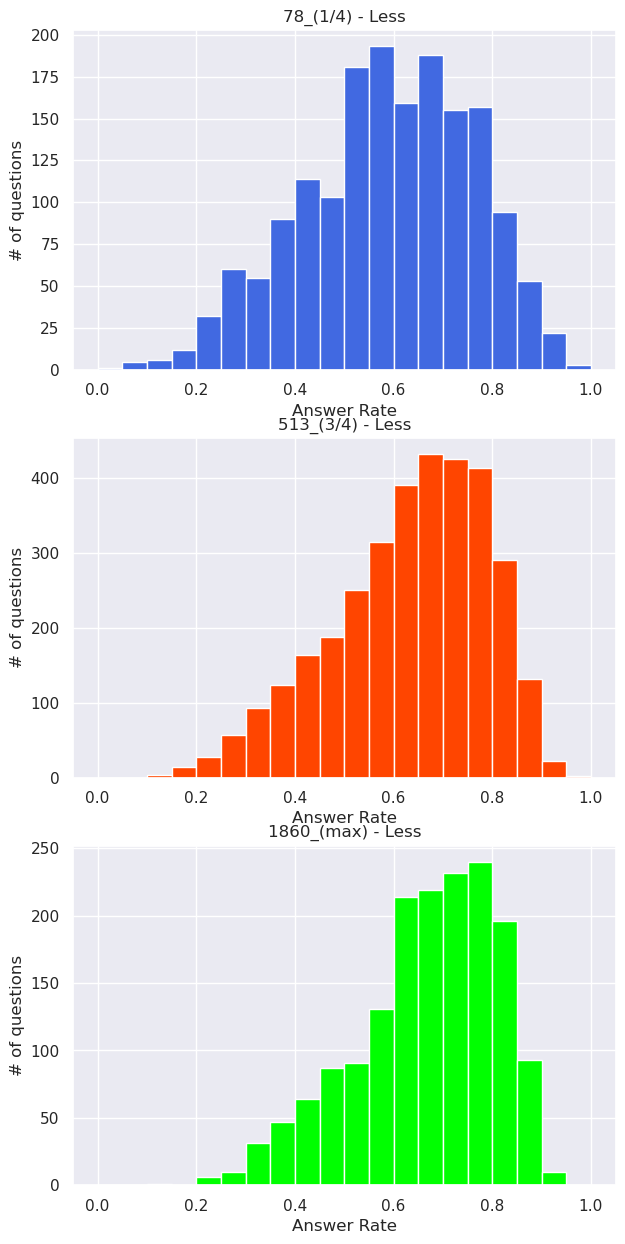

In [34]:
fig, axes = plt.subplots(3,1, figsize=(7,15))

interval_questions = [0,78,513,1860]
name_list = ['78_(1/4) - Less', '513_(3/4) - Less', '1860_(max) - Less']
color_list = ['royalblue', 'orangered', 'lime']

for i in range(3):
    axes[i].hist(
        x = stu_groupby[(stu_groupby['assessmentItemID']>interval_questions[i]) & 
                        (stu_groupby['assessmentItemID']<=interval_questions[i+1])]['answerCode'],
        bins=20, range=(0,1), color=color_list[i], 
    )

    axes[i].set_xlabel('Answer Rate')
    axes[i].set_ylabel('# of questions')
    axes[i].set_title(name_list[i])



plt.show()

#### 더 많이 노출된 Tag가 정답률이 높은가?

In [36]:
tag_groupby = df.groupby('KnowledgeTag').agg({
    'userID' : 'count',
    'answerCode' : percentile
})
tag_groupby.describe()

userID  answerCode
count    912.000000  912.000000
mean    2485.291667    0.615524
std     1732.086925    0.148329
min       44.000000    0.188940
25%     1025.250000    0.498239
50%     2204.000000    0.599585
75%     4052.750000    0.740288
max    12892.000000    0.977778

In [38]:
print(f"태그를 풀었던 사용자의 수와 정답률 사이 상관관계 : {tag_groupby.corr()['userID']['answerCode']}")

태그를 풀었던 사용자의 수와 정답률 사이 상관관계 : 0.37626974341116365


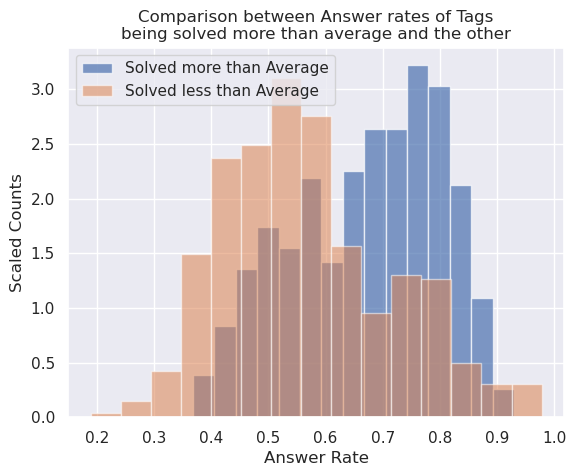

In [39]:
# 태그를 푼 사람과 정답률간 상관관계를 파악하기 위함
fig, ax = plt.subplots()

tag_ans_mean = tag_groupby['userID'].mean()
ax.set_xlabel('Answer Rate')
ax.set_ylabel('Scaled Counts')
ax.set_title('Comparison between Answer rates of Tags\nbeing solved more than average and the other')

tag_groupby[tag_groupby['userID'] >= tag_ans_mean]['answerCode'].hist(
    ax=ax, alpha=0.7, bins=15, density=1, stacked=True, label='Solved more than Average'
)
tag_groupby[tag_groupby['userID'] < tag_ans_mean]['answerCode'].hist(
    ax=ax, alpha=0.55, bins=15, density=1, stacked=True, label='Solved less than Average'
)
ax.legend()

흥미로운 결과가 나왔다고 생각한다. 태그와 관련성이 많이 깊다. 학생이 들이 적게 푼 태그의 경우 정답률이 낮게 나왔고 학생들이 많이 푼 태그의 경우 정답률이 높게 나왔다. 
이후에는 태그와 마지막 문제를 맞췄는지 틀렸는지에 대한 상관관계를 확인해보겠다.


#### 마지막 문제로 나온 태그와 대한 정답률과 노출이 된 정도와 정답 여부

In [8]:
# user 별로 마지막 sequence의 해당 columns를 가져오는 함수
def get_final(x):
    return x[-1:]

# user 별 마지막 문제의 tag, 정답여부 가져옴
uid_groupby = df.groupby('userID').agg({
    'KnowledgeTag' : get_final, 
    'answerCode' : get_final})
uid_groupby

KnowledgeTag  answerCode
userID                          
0               2725           0
1               2648           1
2                428           0
5               8431           1
6               7817           0
...              ...         ...
7436             331           0
7437            7226           0
7438            1934           1
7440            1984           0
7441            8836           1

[6698 rows x 2 columns]

In [9]:
# 겹치는 태그가 많으면 데이터가 많이 없다는 의미이므로 별로 좋지 않음
uid_groupby['KnowledgeTag'].value_counts()


9125    93
8420    92
8433    89
1721    82
8404    80
        ..
1002     1
9829     1
9070     1
7941     1
7226     1
Name: KnowledgeTag, Length: 487, dtype: int64

In [10]:
uid_groupby['KnowledgeTag'].nunique()

487

In [11]:
# tag당 정답률과 푼 문제수를 가져오자
def percentile(s):
    return np.sum(s) / len(s)

tag_groupby = df.groupby('KnowledgeTag').agg({
    'userID' : 'count',
    'answerCode' : percentile
})

tag_groupby.rename(columns={'userID' : 'count', 'answerCode' : 'answerrate'}, inplace=True)
tag_groupby

count  answerrate
KnowledgeTag                   
23             1800    0.584444
24              358    0.614525
25               92    0.858696
26             2432    0.614309
30              539    0.536178
...             ...         ...
11253          4282    0.739374
11265           454    0.676211
11269          2417    0.557716
11270           261    0.478927
11271           522    0.446360

[912 rows x 2 columns]

In [12]:
# Merge
new_df = pd.merge(uid_groupby,tag_groupby, on='KnowledgeTag', how='inner')
new_df

KnowledgeTag  answerCode  count  answerrate
0             2725           0   1444    0.301939
1             2725           0   1444    0.301939
2             2725           0   1444    0.301939
3             2725           0   1444    0.301939
4             2725           0   1444    0.301939
...            ...         ...    ...         ...
6693          7926           0   4236    0.631256
6694          8910           0   1760    0.493750
6695            31           0   1123    0.552983
6696           331           0   1343    0.728965
6697          7226           0   4465    0.799552

[6698 rows x 4 columns]

In [13]:
new_df.describe()

KnowledgeTag   answerCode         count   answerrate
count   6698.000000  6698.000000   6698.000000  6698.000000
mean    5420.311138     0.478949   3060.820096     0.639131
std     3438.538960     0.499594   1558.704071     0.145094
min       23.000000     0.000000     87.000000     0.188940
25%     1964.000000     0.000000   1794.000000     0.537484
50%     7075.000000     0.000000   3150.500000     0.661432
75%     8403.000000     1.000000   4249.000000     0.752301
max    11269.000000     1.000000  10734.000000     0.927544

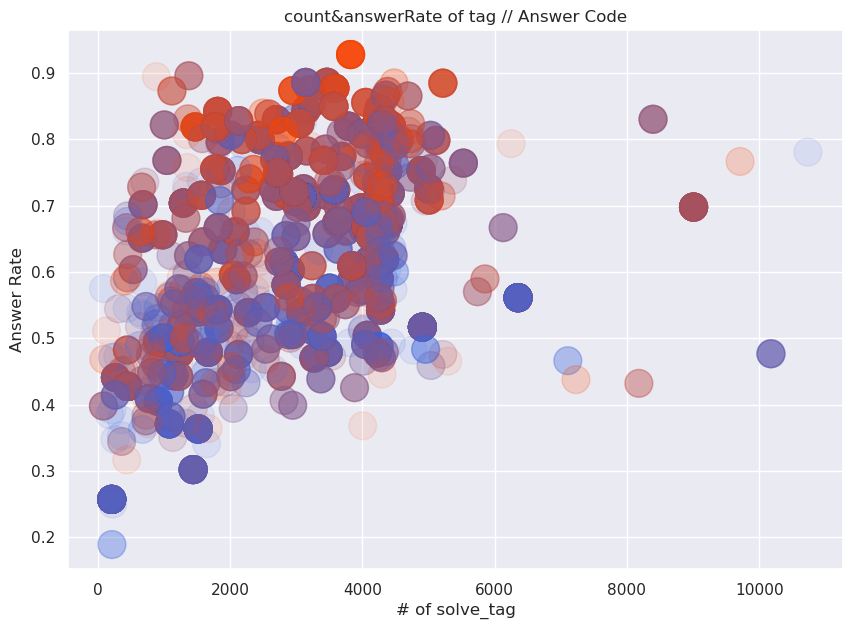

In [14]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)

colors = ['royalblue' if ac == 0 else 'orangered' for ac in new_df['answerCode']]

ax.scatter(
    x = new_df['count'],
    y = new_df['answerrate'],
    c = colors,
    alpha=0.1,
    s = 400
)
ax.set_xlabel('# of solve_tag')
ax.set_ylabel('Answer Rate')
ax.set_title('count&answerRate of tag // Answer Code')

plt.show()

정말 결과가 엉망 진창이다. 당연하게도 480개 정도 밖에 안되는 tag를 가지고 했으니 당연한 결과이다..

0,1을 구분하는 df를 새로 만든 뒤 다시 그래프를 그려보자

In [15]:
# 분할
df_answerCode_0 = new_df[new_df['answerCode'] == 0]
df_answerCode_1 = new_df[new_df['answerCode'] == 1]

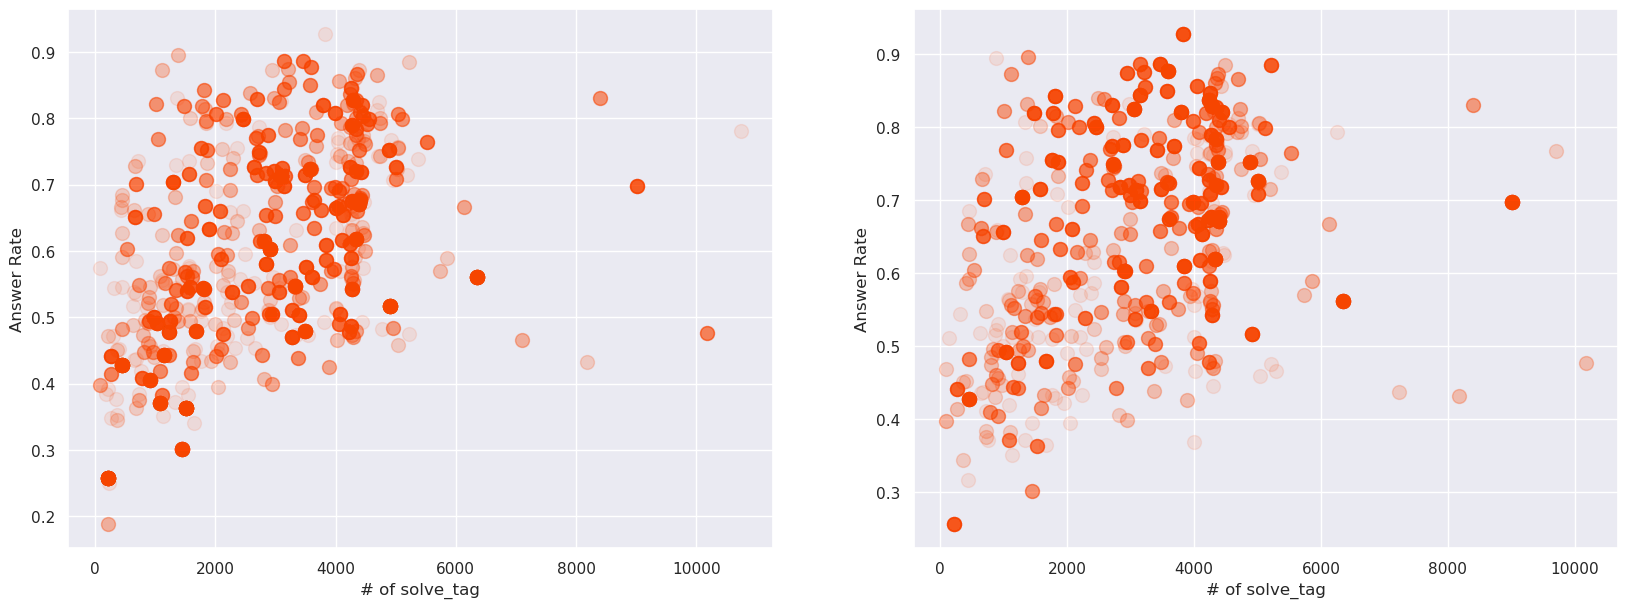

In [23]:
# Draw Graph ... Scatter!!
fig, axes = plt.subplots(1, 2, figsize=(20,7))


colors = ['royalblue','orangered' ]
df_answerCode = [df_answerCode_0, df_answerCode_1]

for i in range(2):
    axes[i].scatter(
        x = df_answerCode[i]['count'],
        y = df_answerCode[i]['answerrate'],
        c = 'orangered',
        alpha=0.1,
        s = 100
    )
    axes[i].set_xlabel('# of solve_tag')
    axes[i].set_ylabel('Answer Rate')


plt.show()

전혀 파악하기 힘들다... 당연한 결과 였나..? 라는 생각이 든다. 애초에 같은 tag는 정해져 있으니 당연하게 같은곳을 찍을 수 밖에 없다...

다음으로는 하나 더 나아가서 마지막 문제의 정답률과 해당 tag의 정답률 비교 + 마지막 문제의 해당 태그의 정답률 과 해당 태그를 푼 사람 비교

In [28]:
# new_df에서 태그별로 groupby를 진행 어차피 answerrate는 태그별로 동일한 값을 가짐

new_df_groupby = new_df.groupby('KnowledgeTag').agg({'answerCode' : percentile, 'answerrate' : lambda x : x[:1]})
new_df_groupby.describe()


answerCode  answerrate
count  487.000000  487.000000
mean     0.454159    0.617334
std      0.311017    0.143798
min      0.000000    0.188940
25%      0.250000    0.503548
50%      0.476190    0.604619
75%      0.666667    0.739211
max      1.000000    0.927544

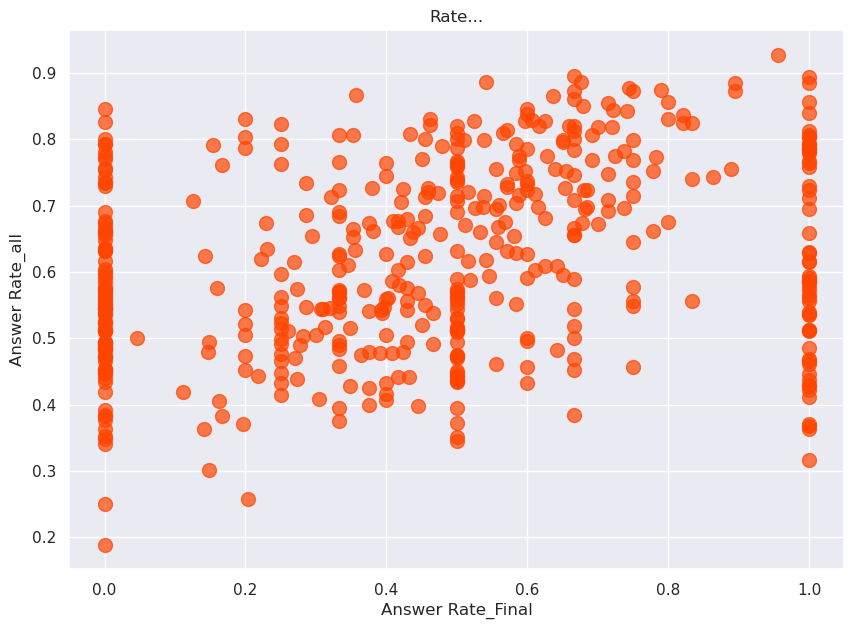

In [30]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)

ax.scatter(
    x = new_df_groupby['answerCode'],
    y = new_df_groupby['answerrate'],
    c = 'orangered',
    alpha=0.7,
    s = 100
)
ax.set_xlabel('Answer Rate_Final')
ax.set_ylabel('Answer Rate_all')
ax.set_title('Rate...')

plt.show()

seaborn에서 sns.lmplot을 사용하면 더 좋은 결과를 볼수 있을 것이다..